In [1]:
import pandas as pd
import re
import numpy as np
import geopandas as gpd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource
from bokeh.palettes import Category20_20
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

In [2]:
categories_test = pd.read_csv("../data/categories_test.csv")
categories = categories_test.drop(["Unnamed: 0", "request_no", "prop_apn", "prop_address", "city", "state", "prop_owner", "reported_problem", "status", "last_activity_date", "last_activity", "last_activity_code"], axis = 1)
categories['date_recv'] = pd.to_datetime(categories['date_recv'])
categories.head(1)

,date_recv,zip,complaint_source,council_district,violations_noted,mapped_loc,violation_category
0,2017-05-04,37218.0,EMAIL,1.0,HIGH WEEDS,"121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718...",LANDSCAPE


In [3]:
# after reading the property standards data

# To pull latitude & longitude from the mapped_loc column to two new columns,
# we first need a function to extract lat and lng

# 121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718, -86.861065)
lat_lng_pattern = re.compile(r'\((.*),\s*(.*)\)', flags=re.MULTILINE)

def extract_lat_lng(address):
    try:
        lat_lng_match = lat_lng_pattern.search(address)
        lat = float(lat_lng_match.group(1))
        lng = float(lat_lng_match.group(2))
        return (lat, lng)
    except:
        return (np.NaN, np.NaN)  #it's important that our list be exactly as long as our df

# Iterating through the mapped_loc column, we apply our function to
# extract lat/lng pairs and store them in a list of tuples.
# Then we can use a list comprehension (or loop) to iterate through the tuple
# and create out two new columns.

lat_lngs = [extract_lat_lng(location) for location in categories.loc[:, 'mapped_loc']]
categories['lat'] = [lat for lat, lng in lat_lngs]
categories['lng'] = [lng for lat, lng in lat_lngs]

In [4]:
categories.head(1)

,date_recv,zip,complaint_source,council_district,violations_noted,mapped_loc,violation_category,lat,lng
0,2017-05-04,37218.0,EMAIL,1.0,HIGH WEEDS,"121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718...",LANDSCAPE,36.213718,-86.861065


In [5]:
#outliers = [<-90, >-83]
categories_1 = categories.drop(categories[categories["lng"]<-90].index)
categories_2 = categories_1.drop(categories_1[categories_1["lng"]>-83].index)
categories_2["violation_category"].value_counts()

WASTE                 11589
VEHICLE                9465
LANDSCAPE              7602
OTHER/MISC             2534
NO_CATEGORY            1410
SIGNAGE                 919
EXTBLD                  775
FENCING                 481
INTBLD                  302
OCCUPANCY               284
PLUMBING                165
ELECTRICAL              126
SHORT_TERM_RENTAL       108
ANIMALS/VERMIN           44
FIRE                     33
SALES                    10
ALCOHOL -- OTHER          3
ALCOHOL -- PERMITS        1
Name: violation_category, dtype: int64

In [6]:
dist_df = gpd.read_file("../data/Council District Outlines (GIS).geojson")
dist_df.head(1)

,first_name,email,res_phone,bus_phone,last_name,position,district,geometry
0,Nick,nick.leonardo@nashville.gov,615-509-6334,615-862-6780,Leonardo,Council Member,1,(POLYGON ((-86.90738248774342 36.3905151283193...


In [7]:
district_df = dist_df.drop(["first_name", "email", "res_phone", "bus_phone", "last_name", "position", "district"], axis = 1)
district_df.head()

,geometry
0,(POLYGON ((-86.90738248774342 36.3905151283193...
1,(POLYGON ((-86.75902399986667 36.2309080000732...
2,(POLYGON ((-86.72850199989709 36.2832840002146...
3,(POLYGON ((-86.68680500011935 36.2867050001350...
4,(POLYGON ((-86.74488864807594 36.0531632050230...


In [8]:
WASTE = categories_2[categories_2["violation_category"].str.contains("WASTE", na = False)]
VEHICLE = categories_2[categories_2["violation_category"].str.contains("VEHICLE", na = False)]
LANDSCAPE = categories_2[categories_2["violation_category"].str.contains("LANDSCAPE", na = False)]
MISC = categories_2[categories_2["violation_category"].str.contains("OTHER/MISC", na = False)]
NO_CATEGORY = categories_2[categories_2["violation_category"].str.contains("NO_CATEGORY", na = False)]
SIGNAGE = categories_2[categories_2["violation_category"].str.contains("SIGNAGE", na = False)]
EXTBLD = categories_2[categories_2["violation_category"].str.contains("EXTBLD", na = False)]
FENCING = categories_2[categories_2["violation_category"].str.contains("FENCING", na = False)]
INTBLD = categories_2[categories_2["violation_category"].str.contains("INTBLD", na = False)]
OCCUPANCY = categories_2[categories_2["violation_category"].str.contains("OCCUPANCY", na = False)]
PLUMBING = categories_2[categories_2["violation_category"].str.contains("PLUMBING", na = False)]
ELECTRICAL = categories_2[categories_2["violation_category"].str.contains("ELECTRICAL", na = False)]
SHORT_TERM_RENTAL = categories_2[categories_2["violation_category"].str.contains("SHORT_TERM_RENTAL", na = False)]
ANIMAL = categories_2[categories_2["violation_category"].str.contains("ANIMALS/VERMIN", na = False)]
FIRE = categories_2[categories_2["violation_category"].str.contains("FIRE", na = False)]
SALES = categories_2[categories_2["violation_category"].str.contains("SALES", na = False)]
ALCOHOL_OTHER = categories_2[categories_2["violation_category"].str.contains("ALCOHOL_OTHER", na = False)]
ALCOHOL_PERMITS = categories_2[categories_2["violation_category"].str.contains("ALCOHOL_PERMITS", na = False)]
NO_CATEGORY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 5 to 35827
Data columns (total 9 columns):
date_recv             1410 non-null datetime64[ns]
zip                   1407 non-null float64
complaint_source      1407 non-null object
council_district      1405 non-null float64
violations_noted      1410 non-null object
mapped_loc            1407 non-null object
violation_category    1410 non-null object
lat                   1377 non-null float64
lng                   1377 non-null float64
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 110.2+ KB


In [9]:
geojson = district_df.to_json()
geo_source = GeoJSONDataSource(geojson=geojson)

output_notebook()

p = figure(plot_width=1000, plot_height=1000, title = "Property Standards Violations in Nashville by Violation Category")

p.xaxis.axis_label = "Longitude"
p.yaxis.axis_label = "Latitude"

p.patches('xs', 'ys', fill_alpha=0, source=geo_source, line_color = "black")

for data, name, color in zip([WASTE, VEHICLE, LANDSCAPE, MISC, NO_CATEGORY, SIGNAGE, EXTBLD, FENCING, INTBLD, OCCUPANCY, 
                              PLUMBING, ELECTRICAL, SHORT_TERM_RENTAL, ANIMAL, FIRE, SALES, ALCOHOL_OTHER, 
                              ALCOHOL_PERMITS], 
                             ["WASTE", "VEHICLE", "LANDSCAPE", "MISC", "NO_CATEGORY", "SIGNAGE", "EXTBLD", "FENCING", 
                              "INTBLD", "OCCUPANCY", "PLUMBING", "ELECTRICAL", "SHORT_TERM_RENTAL", "ANIMAL", "FIRE", 
                              "SALES", "ALCOHOL_OTHER", "ALCOHOL_PERMITS"], Category20_20):
    combined = pd.DataFrame(data)
    p.circle(combined["lng"], combined["lat"], line_alpha = 0, color=color, size = 5, legend = name)

p.legend.location = "top_right"
p.legend.click_policy="hide"

show(p)

Loading BokehJS ...

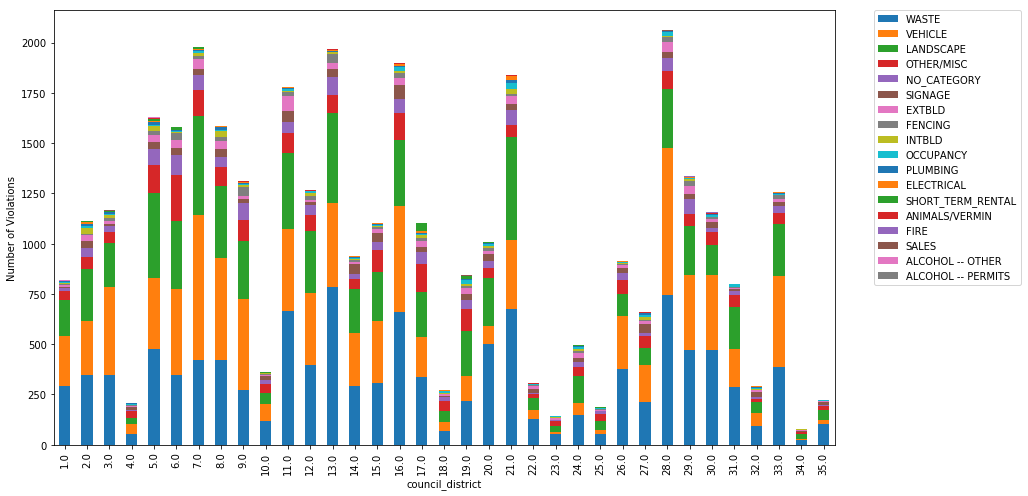

In [10]:
categories_3 = categories_2.groupby(['council_district', 'violation_category'])['council_district'].count().unstack('violation_category').fillna(0)
categories_3[["WASTE", "VEHICLE", "LANDSCAPE", "OTHER/MISC", "NO_CATEGORY", "SIGNAGE", "EXTBLD", "FENCING", "INTBLD", "OCCUPANCY", 
     "PLUMBING", "ELECTRICAL", "SHORT_TERM_RENTAL", "ANIMALS/VERMIN", "FIRE", "SALES", "ALCOHOL -- OTHER", 
     "ALCOHOL -- PERMITS"]].plot(kind='bar', stacked=True, figsize = (14, 8))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Number of Violations")

plt.show()

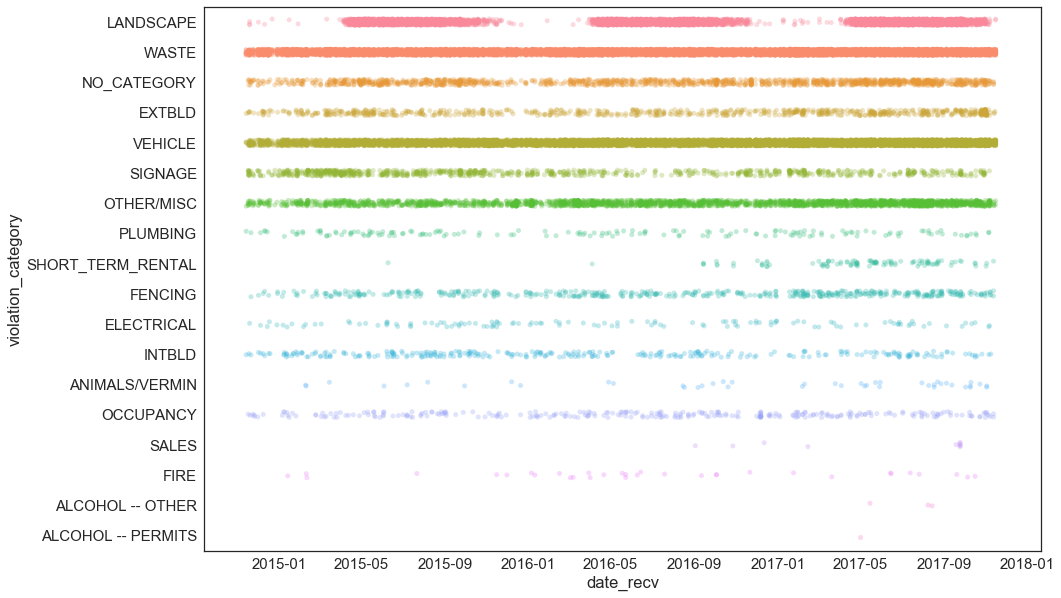

In [11]:
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.stripplot(x="date_recv", y="violation_category", data=categories_2, jitter=True, alpha = .3)

(array([  1.73890000e+04,   4.47500000e+03,   1.38700000e+03,
          5.72000000e+02,   2.11000000e+02,   1.07000000e+02,
          4.90000000e+01,   2.80000000e+01,   0.00000000e+00,
          7.00000000e+00,   8.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.  ,   1.88,   2.76,   3.64,   4.52,   5.4 ,   6.28,   7.16,
          8.04,   8.92,   9.8 ,  10.68,  11.56,  12.44,  13.32,  14.2 ,
         15.08,  15.96,  16.84,  17.72,  18.6 ,  19.48,  20.36,  21.24,
         22.12,  23.  ]),
 <a list of 25 Patch objects>)

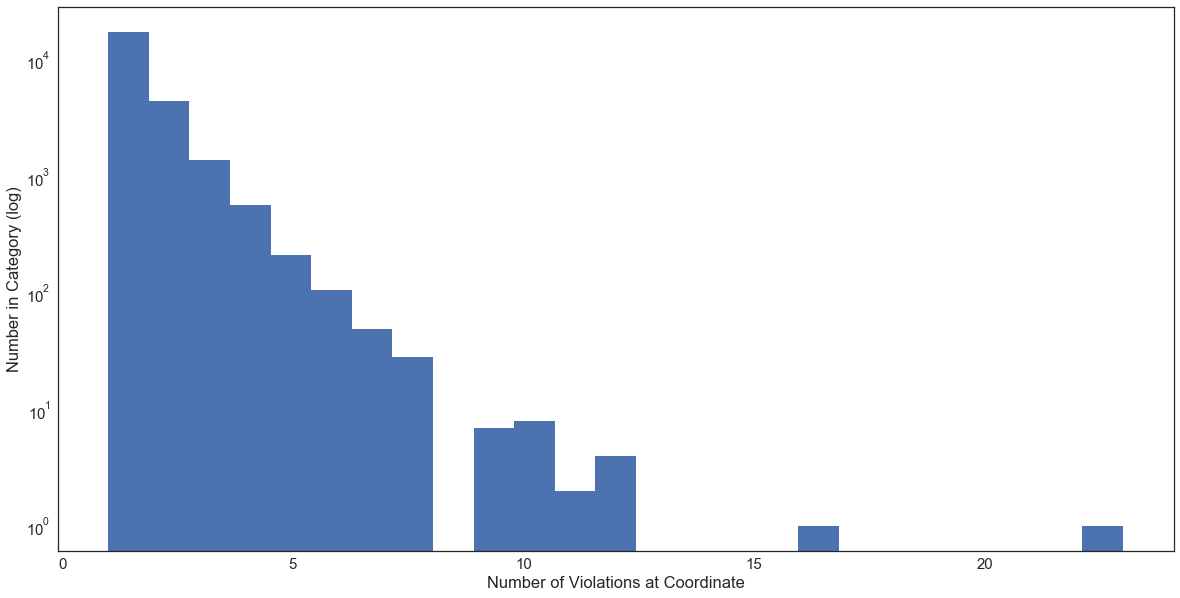

In [12]:
group_latlng = categories_2.groupby(["lat", "lng"]).agg(len)
#group_latlng["violation_category"]

plt.figure(figsize=(20,10))
plt.yscale('log', nonposy='clip')
plt.ylabel('Number in Category (log)')
plt.xlabel('Number of Violations at Coordinate')
plt.hist(group_latlng["violation_category"], bins = 25)

In [13]:
group_latlng[group_latlng["violation_category"]>20]

,,date_recv,zip,complaint_source,council_district,violations_noted,mapped_loc,violation_category
lat,lng,,,,,,,
36.051935,-86.714561,23,23.0,23,23.0,23,23,23


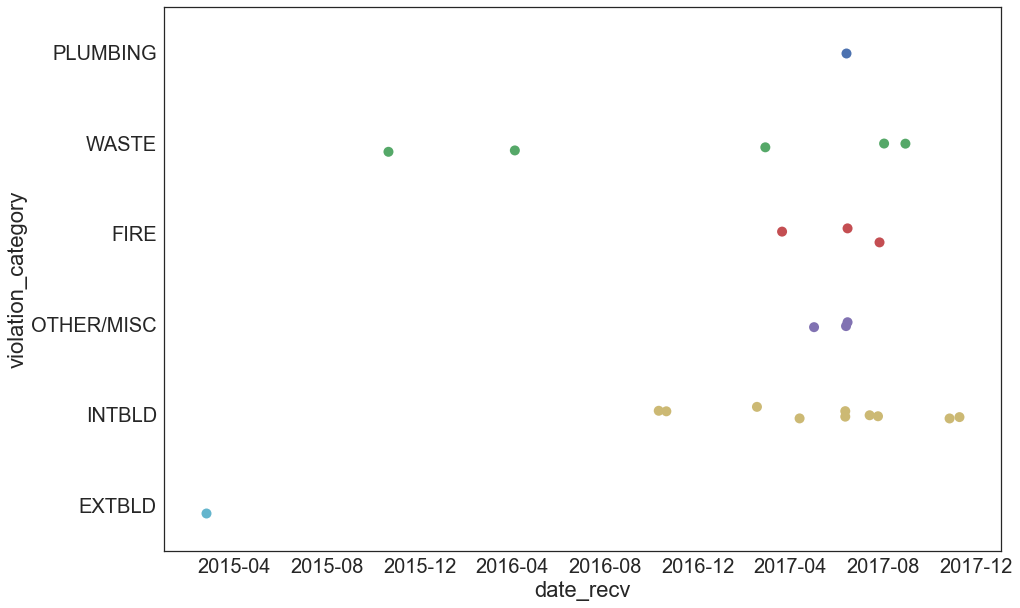

In [14]:
same_lat = categories_2[categories_2["lat"].isin([36.051935])&categories_2["lng"].isin([-86.714561])]
#same_lat
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.stripplot(x="date_recv", y="violation_category", data=same_lat, jitter=True, size = 10)

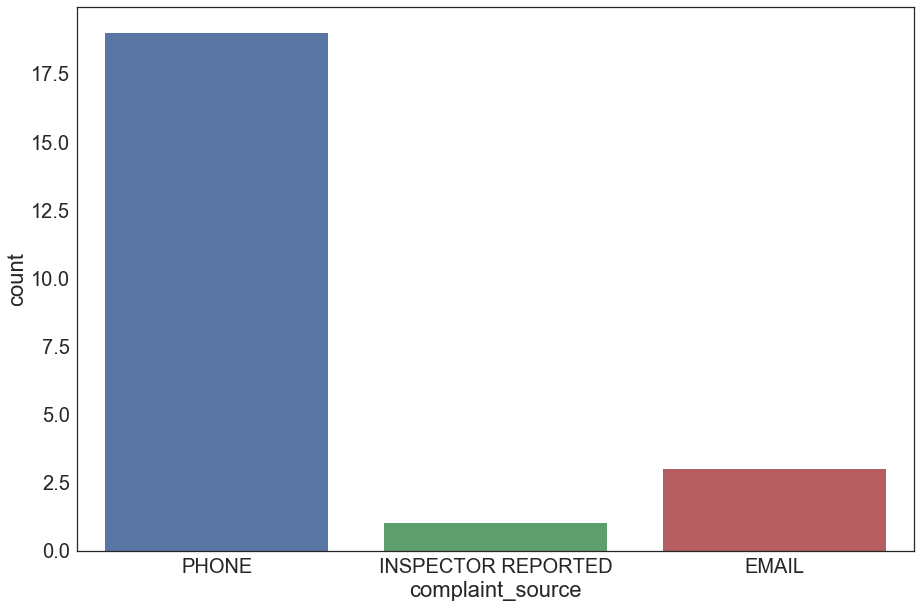

In [15]:
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.countplot(x = "complaint_source", data = same_lat, )

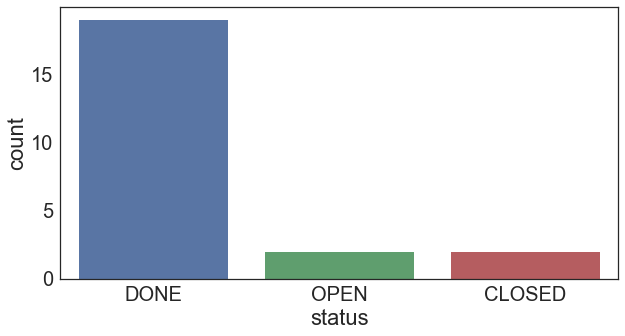

In [16]:
categories_status = categories_test.drop(["Unnamed: 0", "request_no", "prop_apn", "prop_address", "city", "state", "prop_owner", "reported_problem", "last_activity_date", "last_activity", "last_activity_code"], axis = 1)

lat_lngs = [extract_lat_lng(location) for location in categories_status.loc[:, 'mapped_loc']]
categories_status['lat'] = [lat for lat, lng in lat_lngs]
categories_status['lng'] = [lng for lat, lng in lat_lngs]

same_lat_status = categories_status[categories_status["lat"].isin([36.051935])&categories_status["lng"].isin([-86.714561])]

sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(10,5))
sns.countplot(x = "status", data = same_lat_status)

In [17]:
map_1 = folium.Map(location=[36.051935, -86.714561], zoom_start=16)
folium.Marker([36.0520584, -86.71748639999998]).add_to(map_1)
map_1